# The Profile Neural Network
This notebook contains code to replicate the results of the PNN realised in a non-sequential machine learning pipeline demonstrated at deRSE-2023. This code is based on the following paper:
>Benedikt Heidrich, Marian Turowski, Nicole Ludwig, Ralf Mikut, and Veit Hagenmeyer. 2020. Forecasting energy time series with profile neural networks. In Proceedings of the Eleventh ACM International Conference on Future Energy Systems (e-Energy ’20). Association for Computing Machinery, New York, NY, USA, 220–230. DOI:https://doi.org/10.1145/3396851.3397683

<br/>

### What is the PNN
Before getting to the code lets briefly look at the PNN. The fundamental assumption behind the PNN is that many time series exhibit calendar driven periodicities which we can use to our advantage to improve forecasting performance. For example, a time series modelling traffic congestion will probably show a strong daily periodicity, with peaks for the rush-hour in the morning and evening as commuters travel to and from work. Furthermore, this traffic congestion time series will show a weekly periodicity when the majority of commuters do not travel to work on the weekend leading to less congestion on Saturday and Sunday. You can observe periodicites in many other time series.

The PNN takes advantage of these calendar periodicites and uses statistical information to improve probabilistic forecasts:
- We calculate a rolling profile by statistically grouping the time series using calendar information.
- This grouping works by considering values that are "similar" according to their calendar information when calculating the statistics, for example the statistics calculated for Monday noon are calculated by considering the values at noon on previous working days. Similarly, the statistics for midnight on saturday are calculated by considering midnight values for previous weekends.
- As a result, we implicitly include the calender-driven periodicites in this statistical information.

This statistical information is not the entire story though:
- The PNN also includes a trend component which predicts the expected value of the time series trend.
- It also includes a colourful noise component which encodes the historical data and exogenous features and predicts the expected value of this colourful noise.

To creat the final forecast:
- All three components are aggregated and the PNN delivers a final expected value prediction.

A far more detailed explanation of the PNN can be found in our paper mentioned above - for now lets focus on the pipeline used to implement it.

### Setting up the Pipeline
Before we start defining the pipeline, we import the necessary dependencies.

In [1]:
from pywatts.modules import Select, ProfileNeuralNetwork
import pandas as pd
from pywatts.callbacks import LinePlotCallback
from pywatts_pipeline.core.summary.summary_formatter import SummaryJSON
from pywatts_pipeline.core.util.computation_mode import ComputationMode
from pywatts_pipeline.core.pipeline import Pipeline
from pywatts.modules import CalendarExtraction, CalendarFeature, RollingMean, TrendExtraction, \
    FunctionModule, SKLearnWrapper, RollingVariance
from pywatts.modules import RollingGroupBy
from pywatts.summaries import RMSE
from pywatts_pipeline.utils._xarray_time_series_utils import numpy_to_xarray
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from utils.load_data import load_elec_data

import warnings
warnings.filterwarnings('ignore')

We also need to define a helper function that calculates the difference between actual values and the profile. The result of this function is used as historical input for the PNN

In [2]:
def get_diff(x, profile):
    return numpy_to_xarray(x.values - profile.values, x)

Now we can define the pipeline. This pipeline:
* Scales the input data.
* Calculates profiles based on the rolling mean of the scaled data, with the rolling mean based on groups classified by calendar information.
* Calculates the difference between the profile and the actual values with the helper function above.
* Extracs the trend from the time series.
* Extracts calendar features.
* Creates a PNN which uses all of these features as inputs.
* Also creates a simple MLP used to compare the performance of the MLP.
* Calculates the RMSE as an evaluation metric

In [3]:
# Create pipeline
pipeline = Pipeline()

# Define a scaler
scaler = SKLearnWrapper(StandardScaler())

# Scale the inptu data
scaled_data = scaler(x=pipeline["load_power_statistics"])

# Create a profile based on the scaled data
scaled_profiles = RollingMean(group_by=RollingGroupBy.WorkdayWeekend, window_size=28)(x=scaled_data, callbacks=[LinePlotCallback("Mean")])

# We need to reshape the scaled data for further use in the pipeline
scaled_data = FunctionModule(lambda x: numpy_to_xarray(x.values.reshape((-1)), x))(x=scaled_data)

# Calculate the difference betweent he profile and the true observations with the previously defined helper function
difference = FunctionModule(get_diff, name="Difference")(x=scaled_data, profile=scaled_profiles)

# Extracts the trend from the time series
trend = TrendExtraction(168, 5)(x=difference)

# Extracts calendar features from the time series
calendar = CalendarExtraction(country="Germany",
                              features=[CalendarFeature.hour_sine,
                                        CalendarFeature.month_sine,
                                        CalendarFeature.hour_cos,
                                        CalendarFeature.month_cos,
                                        CalendarFeature.workday,
                                        # CalendarFeature.holiday
                                        ])(
    x=pipeline["load_power_statistics"])

# Since the difference is not available in the future, we only consider historical values
# In this case we select values from 36 hours ago, up until now, in hourly steps
sampled_difference = Select(-36, 0, 1, name="Sample Historical Values")(x=difference)

# We also create samples of all the other features from now, up until 24 hours in the future
sampled_calendar = Select(0, 24, 1, name="Sample calendar")(x=calendar)
sampled_profiles = Select(0, 24, 1, name="Sample profile")(x=scaled_profiles)
sampled_trend = Select(0, 24, 1, name="Sample trend")(x=trend)

# We also need to select the ground truth - both scaled and unscaled for the valuation
scaled_target = Select(0, 24, 1, name="Sample scaled GT")(x=scaled_data)
target = Select(0, 24, 1, name="GT")(x=pipeline["load_power_statistics"])

# Define the PNN
prob_pnn = ProfileNeuralNetwork(epochs=50)(historical_input=sampled_difference,
                 calendar=sampled_calendar,
                 profile=sampled_profiles,
                 trend=sampled_trend,
                 target=scaled_target,
                 )

# Define the MLP
mlp = SKLearnWrapper(MLPRegressor())(historical_input=sampled_difference,
                                                calendar=sampled_calendar,
                                                profile=sampled_profiles,
                                                trend=sampled_trend,
                                                target=scaled_target,
                                                callbacks=[LinePlotCallback("LR")])

# To evaluate on the correct scale, we need to unscale the resulting forecasts
unscaled_forecast = scaler(x=prob_pnn, computation_mode=ComputationMode.Transform, method="inverse_transform")
mlp = scaler(x=mlp, computation_mode=ComputationMode.Transform, method="inverse_transform")

# Calculate the RMSE
rmse = RMSE()(unscaled_pnn_=unscaled_forecast,
              mlp=mlp, y=target)

pyWATTS allows us to automatically visualise the defined pipeline. This is particularly useful as a sanity check to make sure the pipeline is actually constructed as we expect. To simplify visualisation, it is possible to skip some steps.

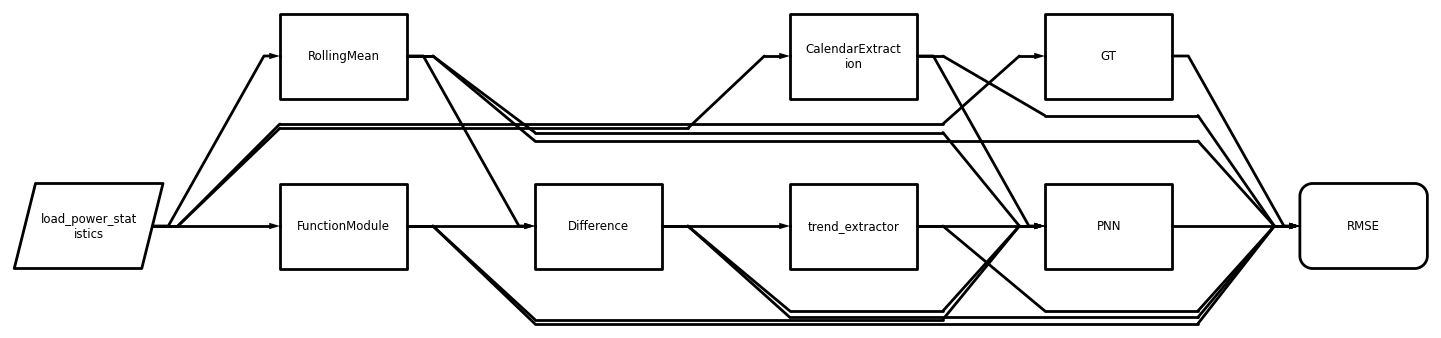

In [4]:
pipeline.draw(skip=["Sample Historical Values", "Sample calendar", "Sample profile",
                    "Sample trend", "Sample scaled GT", "StandardScaler", "MLPRegressor"]).draw()

### Reading in the Data
To train and evaluate the pipeline we need data. In this case we:
* Automatically load the data and create a train and test split.
* We use a subset of hourly electricity load values for the state of Baden-Württemberg in Germany, taken from the Open Power Systems Data portal.

In [5]:
# Load data
data = load_elec_data()

# Create train and test splits
train_data = data[:6000]
test_data = data[6000:]

### Training the Pipeline
To train the pipeline, we simply call the __pipeline.train()__ method

In [6]:
results_train, summary_train = pipeline.train(train_data)

Epoch 1/50


2023-02-17 11:45:54.571168: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


38/38 [==============================] - 1s 11ms/step - loss: 8.5097 - _root_mean_squared_error: 0.5700 - val_loss: 7.8214 - val__root_mean_squared_error: 0.5422
Epoch 2/50
38/38 [==============================] - 0s 6ms/step - loss: 4.9279 - _root_mean_squared_error: 0.4273 - val_loss: 4.5543 - val__root_mean_squared_error: 0.4134
Epoch 3/50
38/38 [==============================] - 0s 6ms/step - loss: 4.0591 - _root_mean_squared_error: 0.3878 - val_loss: 3.0424 - val__root_mean_squared_error: 0.3395
Epoch 4/50
38/38 [==============================] - 0s 7ms/step - loss: 3.4965 - _root_mean_squared_error: 0.3606 - val_loss: 2.0832 - val__root_mean_squared_error: 0.2825
Epoch 5/50
38/38 [==============================] - 0s 7ms/step - loss: 3.1607 - _root_mean_squared_error: 0.3418 - val_loss: 1.7330 - val__root_mean_squared_error: 0.2584
Epoch 6/50
38/38 [==============================] - 0s 7ms/step - loss: 2.9891 - _root_mean_squared_error: 0.3310 - val_loss: 1.4733 - val__root_mean_

### Testing the pipeline
Finally we test the pipeline. This is achieved by calling the __pipeline.test()__ method on the test data set.

The RMSE is printed to compare the accuracy of the PNN and MLP

In [7]:
_, summary = pipeline.test(test_data, reset=True, summary_formatter=SummaryJSON())
pd.DataFrame(summary["Summary"]["RMSE"])

85/85 [==============================] - 0s 874us/step


,additional_information,results
mlp,,3380.013065
unscaled_pnn_,,3200.468913


We hope this example helped you understand pyWATTS. If you have any questions feel free to contact us via [pywatts-team@iai.kit.edu](mailto:pywatts-team@iai.kit.edu)